In [7]:
from data_preprocessing.DataLoader import DataLoader
from data_preprocessing.DataPreprocessing import DataPreprocessing
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import pandas as pd
import datetime as dt
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from data_preprocessing.DataLoader import DataLoader
from sklearn.metrics import mean_squared_error, r2_score

In [11]:
data = DataLoader.load_data_from_path("data/")
united = DataPreprocessing.prepareDate(data)

dataPreprocesing = DataPreprocessing()

united = dataPreprocesing.oneHotEncode(united, {'city', 'delivery_company', 'time_of_day', 'weekday'})

united['deltas'] = pd.to_numeric(united['deltas'].dt.days, downcast='integer')


# normalizacja deltas
# unitated['deltas'] = unitated['deltas'] /unitated['deltas'].abs().max()


train, test = train_test_split(united, test_size=0.2)
X_train = train.loc[:, train.columns != 'deltas']
y_train = train['deltas']

X_test = test.loc[:, test.columns != 'deltas']
y_test = test['deltas']


regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

print('Coefficients: \n', regr.coef_)
print('Mean squared error: %.2f'
% mean_squared_error(y_test, y_pred))
print('Coefficient of determination: %.2f'
% r2_score(y_test, y_pred))

Coefficients: 
 [ 3.80859331e+11  3.80859331e+11  3.80859331e+11 -2.57446672e+13
 -2.57446672e+13 -2.57446672e+13 -2.57446672e+13 -2.57446672e+13
 -2.57446672e+13 -2.57446672e+13 -2.57446672e+13 -1.31913943e+12
 -1.31913943e+12 -1.31913943e+12 -1.31913943e+12 -1.31913943e+12
 -1.31913943e+12 -1.31913943e+12  6.49142073e+10  6.49142073e+10
  6.49142073e+10  6.49142073e+10]
Mean squared error: 0.33
Coefficient of determination: 0.56


In [12]:
y_train

5262    2
2299    1
7000    2
578     3
1092    1
       ..
1837    2
3862    1
1314    1
3573    1
1279    3
Name: deltas, Length: 5994, dtype: int8

In [ ]:
X_train

In [ ]:
y_test.to_numpy()

In [ ]:
y_pred.shape

In [ ]:
y_test[0:10]

In [10]:
y_pred[0:10]

array([1.69843382, 1.41918591, 1.39672924, 0.51981977, 0.96153206,
       1.80231741, 0.92974639, 1.5109906 , 1.78705382, 0.89347566])

In [11]:
y_test[0:10]-y_pred[0:10]

2320   -0.698434
338    -0.419186
7451   -0.396729
5608    0.480180
4814    0.038468
7353    0.197683
1981   -0.929746
4190   -0.510991
958     0.212946
3127    0.106524
Name: deltas, dtype: float64

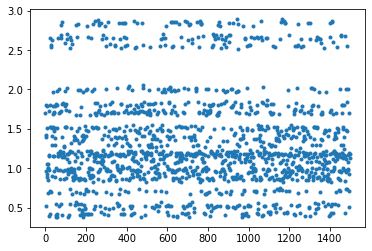

In [12]:
plt.plot(y_pred,".")

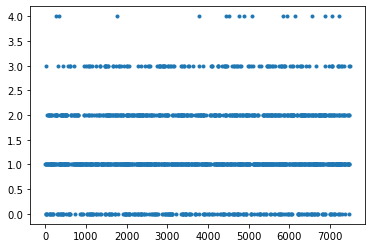

In [13]:
plt.plot(y_test,".")

In [ ]:
import pickle
f = open('models/linear_regresion_1.0.0.pickle', 'wb')
pickle.dump(model, f)
f.close()